# erreur sur charge hydraulique stratifié

In [1]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. Chargement des données et définition d'un objet ``Column``

On doit d'abord récupérer les données issues des capteurs, qui se trouvent dans le dossier ``data``.

In [2]:
capteur_riviere = pd.read_csv("../data/Point034_processed/processed_pressures.csv", sep = ',', names = ['dates', 'tension', 'temperature_riviere'], skiprows=1)
capteur_ZH = pd.read_csv("../data/Point034_processed/processed_temperatures.csv", sep = ',', names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
etalonage_capteur_riv = pd.read_csv("../configuration/pressure_sensors/P508.csv")

On définit une fonction pour convertir les dates des dataframe, cela peut éviter certains problèmes.

In [3]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

convertDates(capteur_riviere)
convertDates(capteur_ZH)

On définit les objets ``dH_measures`` et ``T_measures``, nécessaires à la création d'un objet ``Column``, qui réalisera les calculs :
- ``dH_measures`` contient les dates des mesures, les mesures de différence de charge, et les températures de la rivière.
- ``T_measures`` contient les dates des mesures, et les températures mesurées par les 4 capteurs de la tige.

In [4]:
# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a
# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + 273.15
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + 273.15
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + 273.15
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + 273.15
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + 273.15

## zhan: un cas simple: $h_{riv}$ cste 

In [5]:
print("H riv before")
capteur_riviere.sample(5)

H riv before


,dates,tension,temperature_riviere,dH
1139,2016-07-10 03:30:00,-0.025482,288.948,0.860934
533,2016-07-03 20:00:00,-0.020235,287.558,0.855946
459,2016-07-03 01:30:00,-0.012897,287.257,0.850625
1150,2016-07-10 06:15:00,-0.026106,288.207,0.860615
393,2016-07-02 09:00:00,-0.010786,286.871,0.848792


In [6]:
capteur_riviere['dH'] = np.mean(capteur_riviere['dH'])
print("H riv after")
capteur_riviere.sample(5)

H riv after


,dates,tension,temperature_riviere,dH
307,2016-07-01 11:30:00,-0.009867,287.775,0.855532
782,2016-07-06 10:15:00,-0.022659,286.228,0.855532
635,2016-07-04 21:30:00,-0.020481,288.649,0.855532
443,2016-07-02 21:30:00,-0.013923,287.797,0.855532
49,2016-06-28 19:00:00,-0.006565,288.769,0.855532


In [7]:

# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

On définit maintenant l'objet ``Column`` à partir d'un dictionnaire.

In [8]:
col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, .4],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

col = Column.from_dict(col_dict)

L'objet créé a déjà un certain nombre d'attributs, certains étant initialisés. Se reporter au code ``core.py``.

In [9]:
temps_en_jours = np.array([i for i in range(len(col._times))]) / (4*24)

## 2. Modèle direct

Le modèle direct calcule les températures au cours du temps dans la colonne. Ensuite, on a accès aux flux, à la RMSE...

### 2.1. Colonne homogène

Pour une colonne homogène, on définit un seul jeu de paramètres, par un tuple ou via la classe ``Param`` :

In [10]:
params = Param(
    moinslog10K = 4,
    n = .1,
    lambda_s = 2,
    rhos_cs = 4e6
)

params_tuple = (4, .1, 2, 4e6)

assert params == params_tuple

Puis on appelle le modèle direct :

In [11]:
col.compute_solve_transi(params, nb_cells=11)

--- Compute Solve Transi ---
One layer : moinslog10K = 4, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0
Done.


### 2.2. Colonne stratifiée

Pour une colonne stratifiée, on doit d'abord définir une liste d'objets ``Layer`` :

## zhan: cas avec $Ss$ cste et deux couche de perméabilité différente

In [12]:
layers_list = layersListCreator([("Couche 1", 0.20, 5, 0.1, 2, 4e6), ("Couche 2", 0.40, 7, 0.1, 2, 4e6)])
# layers_list = layersListCreator([("Couche 1", 0.10, 4, 0.1, 2, 4e6), ("Couche 2", 0.20, 6, 0.1, 2, 4e6), ("Couche 3", 0.30, 7, 0.1, 2, 4e6), ("Couche 4", 0.40, 8, 0.1, 2, 4e6)])

Puis on appelle le modèle direct :

## zhan: réalisation de l'équation de diffusivité

In [13]:
dH_measures = np.array([d for _, (d, _) in dH_measures])
print("condition aux limites de la rivière")
print(dH_measures)
print(len(dH_measures))

condition aux limites de la rivière
[0.85553173 0.85553173 0.85553173 ... 0.85553173 0.85553173 0.85553173]
1309


In [14]:
# H_init_pyheatmy = self._dH[0] - self._dH[0] * self._z_solve / self._real_z[-1]

charge hydraulique sur chaque interface [0.85553173 0.84706112 0.        ]


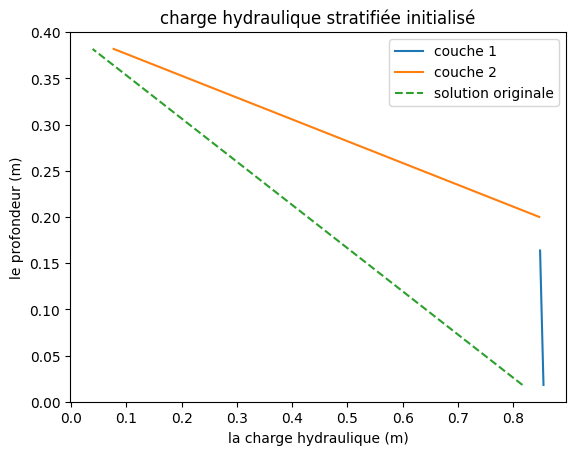

--- Compute Solve Transi ---
Couche 1 : ends at 0.2 m. Parametres(moinslog10K=5, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Couche 2 : ends at 0.4 m. Parametres(moinslog10K=7, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Hinter [0.85553173 0.84706112 0.        ]


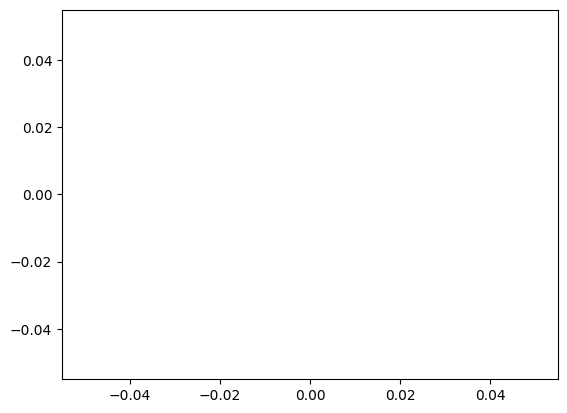

zhan moinslog10K_list [5. 5. 5. 5. 5. 7. 7. 7. 7. 7. 7.]
length de chaque couche 
5
6
zhan 4
0.8486012268093645
0.8470611156899283
0.8470611156899281


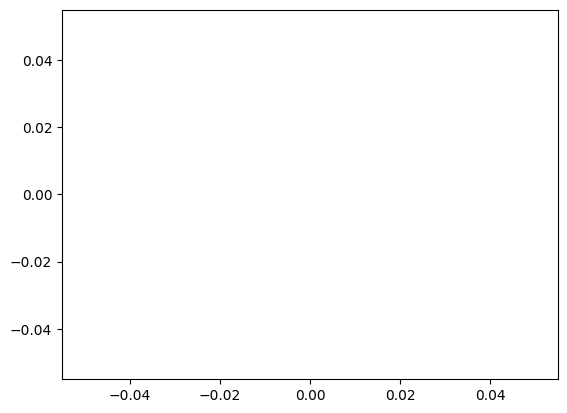

H_riv [0.85476167 0.85476167 0.85476167 ... 0.85476167 0.85476167 0.85476167]
H_aq [0. 0. 0. ... 0. 0. 0.]
zhan ncell 11
Done.


In [15]:
col.compute_solve_transi(layers_list, nb_cells=11)

### zhan: voyons que le charge hydraulique initialisé en suivant la loi de conservation de flux sur chaque d'interface est comme ci-dessus, maintenant nous étudions son évaluation avec le temps

[0.01818182 0.05454545 0.09090909 0.12727273 0.16363636 0.2
 0.23636364 0.27272727 0.30909091 0.34545455 0.38181818]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


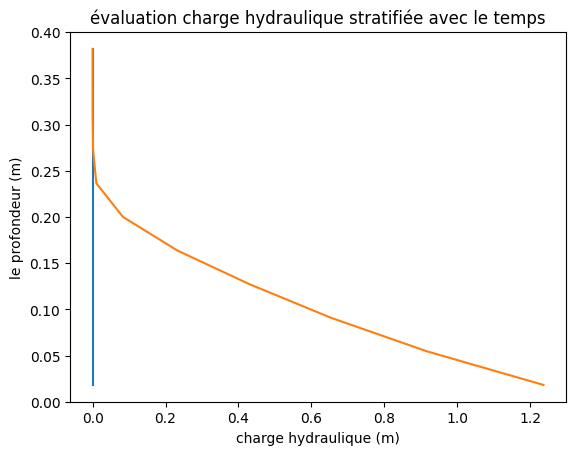

In [22]:
print(col._z_solve)
print(col._H_res[:,0])
for idx in range(2):
    plt.plot(col._H_res[:,idx], col._z_solve, label = str(idx * 15) + 'min')
plt.title('évaluation charge hydraulique stratifiée avec le temps')
plt.xlabel('charge hydraulique (m)')
plt.ylabel('le profondeur (m)')
plt.show()

### zhan: la charge hydraulique converge vers la solution false

### étudions la perméabilité sur l'interface

In [17]:
# expérience
H_init = col._H_res[:, 0]

print(col._H_res[0, :])
col._H_res[-1, :] = np.array([col._H_res[-1, 0] for _ in col._H_res[-1, :]])
print(col._H_res[-1, :])
# cas deux couche
# variable Hbm, Hbp, dHbm, dHbp, ddHbm, ddHbp
K1 = 1e-5
K2 = 1e-6
h0 = 0.004
h1 = h0 / 2
h2 = h0 / 2
A_layer = np.zeros((6,6))
b_layer = np.zeros(6)
A_layer[0, 0] = 1
A_layer[0, 1] = -1
A_layer[1, 2] = K1
A_layer[1, 3] = -K2
A_layer[2, 0] = 1
A_layer[2, 2] = -h1
A_layer[2, 4] = h1 * h1  / 2
A_layer[3, 0] = 1
A_layer[3, 2] =  -(h0 + h1)
A_layer[3, 4] = (h0 + h1)*(h0 + h1) / 2
A_layer[4, 1] = 1
A_layer[4, 3] = h2
A_layer[4, 5] = h2 * h2  / 2
A_layer[5, 1] = 1
A_layer[5, 3] = h0 + h2
A_layer[5, 5] = (h0 + h2) * (h0 + h2) / 2
b_layer = np.array([0, 0, H_init[49], H_init[48], H_init[50], H_init[51]])
H_layer = np.linalg.solve(A_layer, b_layer)
print(H_init[49], H_init[50])
print(H_layer)
plt.scatter(H_init[40:60], col._z_solve[40:60], s = 3)
plt.scatter(H_layer[0], 0.2, c = 'r', s = 3, label = 'interface value')
plt.xlabel('charge hydraulique')
plt.ylabel('profondeur')
plt.legend()
plt.show()


[0.         1.2364086  0.51581985 ... 0.81590873 0.8159087  0.81590873]
[0. 0. 0. ... 0. 0. 0.]


IndexError: index 49 is out of bounds for axis 0 with size 11

In [ ]:
H_init_new = np.zeros(101)
H_init_new[0:50] = H_init[0:50]
H_init_new[51:101] = H_init[50:100]
H_init_new[50] = H_layer[0]

In [ ]:
def tri_product(a, b, c, d):
    """
    Computes AB where :
        - A is tridiagonal, with a, b and c as diagonals (from bottom to top)
        - B is a vector represented by d
    """
    n = len(d)
    res = np.zeros(n)

    ac = a
    bc = b
    cc = c
    dc = d

    res[0] = dc[0] * bc[0] + dc[1] * cc[0]
    res[n - 1] = dc[n - 1] * bc[n - 1] + dc[n - 2] * ac[n - 2]

    for ix in range(1, n - 1):
        res[ix] = ac[ix - 1] * dc[ix - 1] + \
            bc[ix] * dc[ix] + cc[ix] * dc[ix + 1]

    return res

def solver(a, b, c, d):
    """
    Solves the system AX = B where :
        - A is tridiagonal, with a, b and c as diagonals (from bottom to top)
        - B is a vector represented by d
    """
    nf = len(d)

    ac = a
    bc = b
    cc = c
    dc = d

    for it in range(1, nf):
        mc = ac[it - 1] / bc[it - 1]
        bc[it] = bc[it] - mc * cc[it - 1]
        dc[it] = dc[it] - mc * dc[it - 1]

    xc = bc
    xc[-1] = dc[-1] / bc[-1]

    for il in range(nf - 2, -1, -1):
        xc[il] = (dc[il] - cc[il] * xc[il + 1]) / bc[il]

    return xc


[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6.]


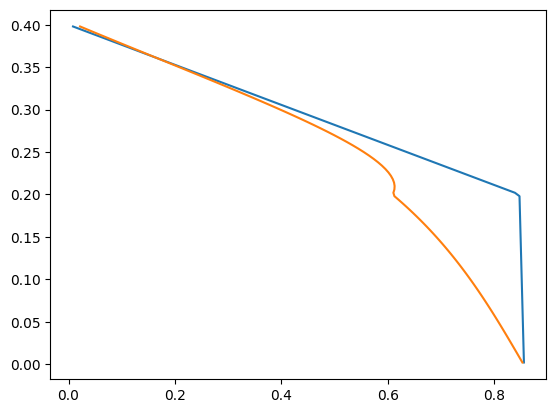

In [ ]:
n_cell = len(H_init)
n_times = 1309

H_res = np.zeros((n_cell, n_times))
Ss_list = np.array([.25 for _ in range(100)])
moinslog10K_list = np.zeros(100)
for idx in range(50):
    moinslog10K_list[idx] = 5
for idx in range(50, 100):
    moinslog10K_list[idx] = 6
print(moinslog10K_list)
H_res[:, 0] = H_init

K_list = 10.0 ** -moinslog10K_list
KsurSs_list = K_list/Ss_list

    # Check if dt is constant :
if True:  # dt is constant so A and B are constant
    alpha = 0.4
    dz = 0.004
    dt = 900.0

    # Defining the 3 diagonals of B
    lower_diagonal_B = KsurSs_list[1:]*alpha/dz**2
    lower_diagonal_B[-1] = 4*KsurSs_list[n_cell - 1]*alpha/(3*dz**2)

    diagonal_B =  1/dt - 2*KsurSs_list*alpha/dz**2
    diagonal_B[0] =  1/dt - 4*KsurSs_list[0]*alpha/dz**2
    diagonal_B[-1] =  1/dt - 4*KsurSs_list[n_cell - 1]*alpha/dz**2

    upper_diagonal_B = KsurSs_list[:-1]*alpha/dz**2
    upper_diagonal_B[0] = 4*KsurSs_list[0]*alpha/(3*dz**2)

    # Defining the 3 diagonals of A
    lower_diagonal_A = - KsurSs_list[1:]*(1-alpha)/dz**2
    lower_diagonal_A[-1] = - 4*KsurSs_list[n_cell - 1]*(1-alpha)/(3*dz**2)

    diagonal_A =  1/dt + 2*KsurSs_list*(1-alpha)/dz**2
    diagonal_A[0] =  1/dt + 4*KsurSs_list[0]*(1-alpha)/dz**2
    diagonal_A[-1] =  1/dt + 4*KsurSs_list[n_cell - 1]*(1-alpha)/dz**2

    upper_diagonal_A = - KsurSs_list[:-1]*(1-alpha)/dz**2
    upper_diagonal_A[0] = - 4*KsurSs_list[0]*(1-alpha)/(3*dz**2)

    for j in range(n_times - 1):
            # Compute H at time times[j+1]

            # Defining c
        c = np.zeros(n_cell)
        c[0] = (8*KsurSs_list[0] / (3*dz**2)) * \
            ((1-alpha)*col._H_res[0, j+1] + alpha*col._H_res[0, j])
        c[-1] = (8*KsurSs_list[n_cell - 1] / (3*dz**2)) * \
            ((1-alpha)*col._H_res[-1, j+1] + alpha*col._H_res[-1, j])

        B_fois_H_plus_c = tri_product(
            lower_diagonal_B, diagonal_B, upper_diagonal_B, H_res[:, j]) + c

        H_res[:, j+1] = solver(lower_diagonal_A, diagonal_A,
                                   upper_diagonal_A, B_fois_H_plus_c)
plt.plot(H_res[:, 0], col._z_solve)
plt.plot(H_res[:, 1], col._z_solve)
plt.show()


In [ ]:
import sympy as sp

# 定义符号变量
K1, K2, h1, h2 = sp.symbols('K1 K2 h1 h2', positive=True)
Um, Up = sp.symbols('Um, Up')

# 定义符号矩阵
A = sp.Matrix([[0, K1, -K2], [1, -h1, 0], [1, 0, h2]])

# 计算逆矩阵
A_inv = A.inv()

# 打印逆矩阵
A_inv
sp.Matrix([0, Um, Up])
A_inv * sp.Matrix([0, Um, Up])

Matrix([
[K1*Um*h2/(K1*h2 + K2*h1) + K2*Up*h1/(K1*h2 + K2*h1)],
[     -K2*Um/(K1*h2 + K2*h1) + K2*Up/(K1*h2 + K2*h1)],
[     -K1*Um/(K1*h2 + K2*h1) + K1*Up/(K1*h2 + K2*h1)]])

### 2.3. Récupération des résultats

**Attention : les paramètres utilisés étant arbitraires, les résultats peuvent ne pas avoir de sens physique.**

On peut récupérer les températures calculées :

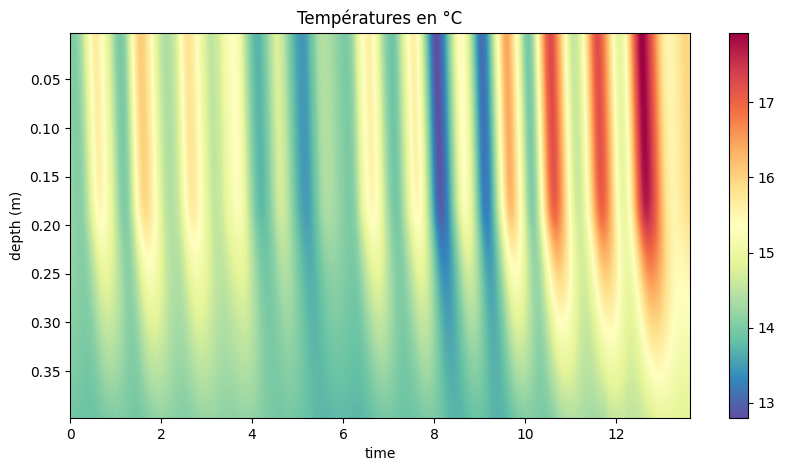

In [ ]:
temperatures = col.get_temps_solve() - 273.15

fig, ax = plt.subplots(figsize=(10, 5), facecolor = 'w')

im = ax.imshow(
    temperatures,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = "Spectral_r"
)

ax.set_xlabel("time")
ax.set_ylabel("depth (m)")
ax.set_title("Températures en °C")
plt.colorbar(im)
plt.show()

Les débits :

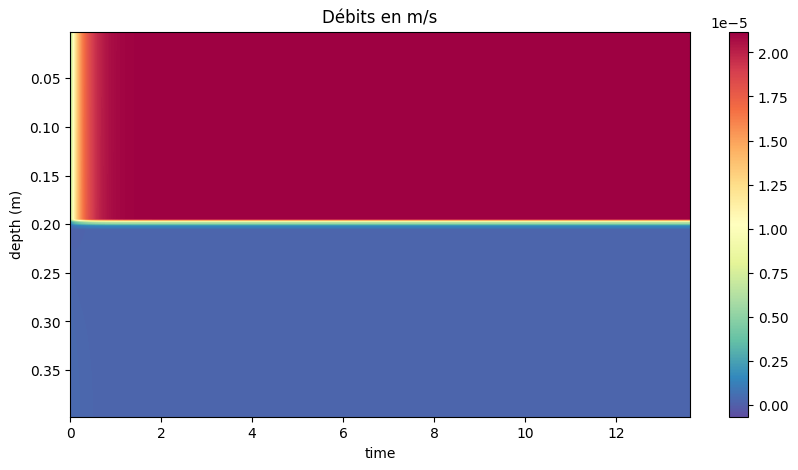

In [ ]:
flows = col.get_flows_solve()

fig, ax = plt.subplots(figsize=(10, 5), facecolor = 'w')

im = ax.imshow(
    flows,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = "Spectral_r"
)

ax.set_xlabel("time")
ax.set_ylabel("depth (m)")
ax.set_title("Débits en m/s")
plt.colorbar(im)
plt.show()

Les flux advectifs et conductifs :

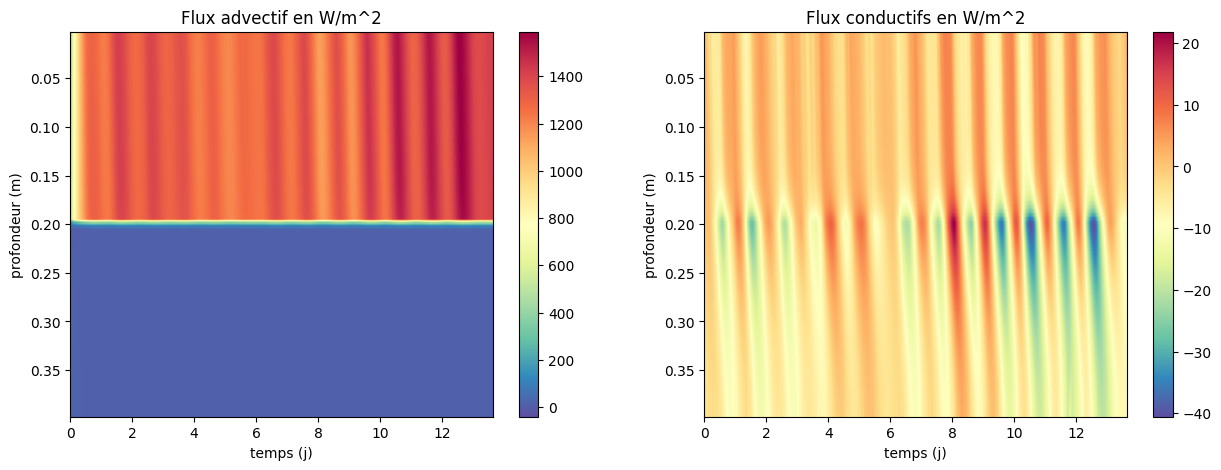

In [ ]:
flux_advectifs = col.get_advec_flows_solve()
flux_conductifs = col.get_conduc_flows_solve()

fig, axes = plt.subplots(1, 2, figsize=(15, 5), facecolor = 'w')

im0 = axes[0].imshow(
    flux_advectifs,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = 'Spectral_r'
)

axes[0].set_xlabel("temps (j)")
axes[0].set_ylabel("profondeur (m)")
axes[0].set_title("Flux advectif en W/m^2")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(
    flux_conductifs,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = 'Spectral_r'
)

axes[1].set_xlabel("temps (j)")
axes[1].set_ylabel("profondeur (m)")
axes[1].set_title("Flux conductifs en W/m^2")
plt.colorbar(im1, ax=axes[1])

plt.show()

On peut aussi afficher tout d'un seul coup : (si on a la bonne version de matplotlib)

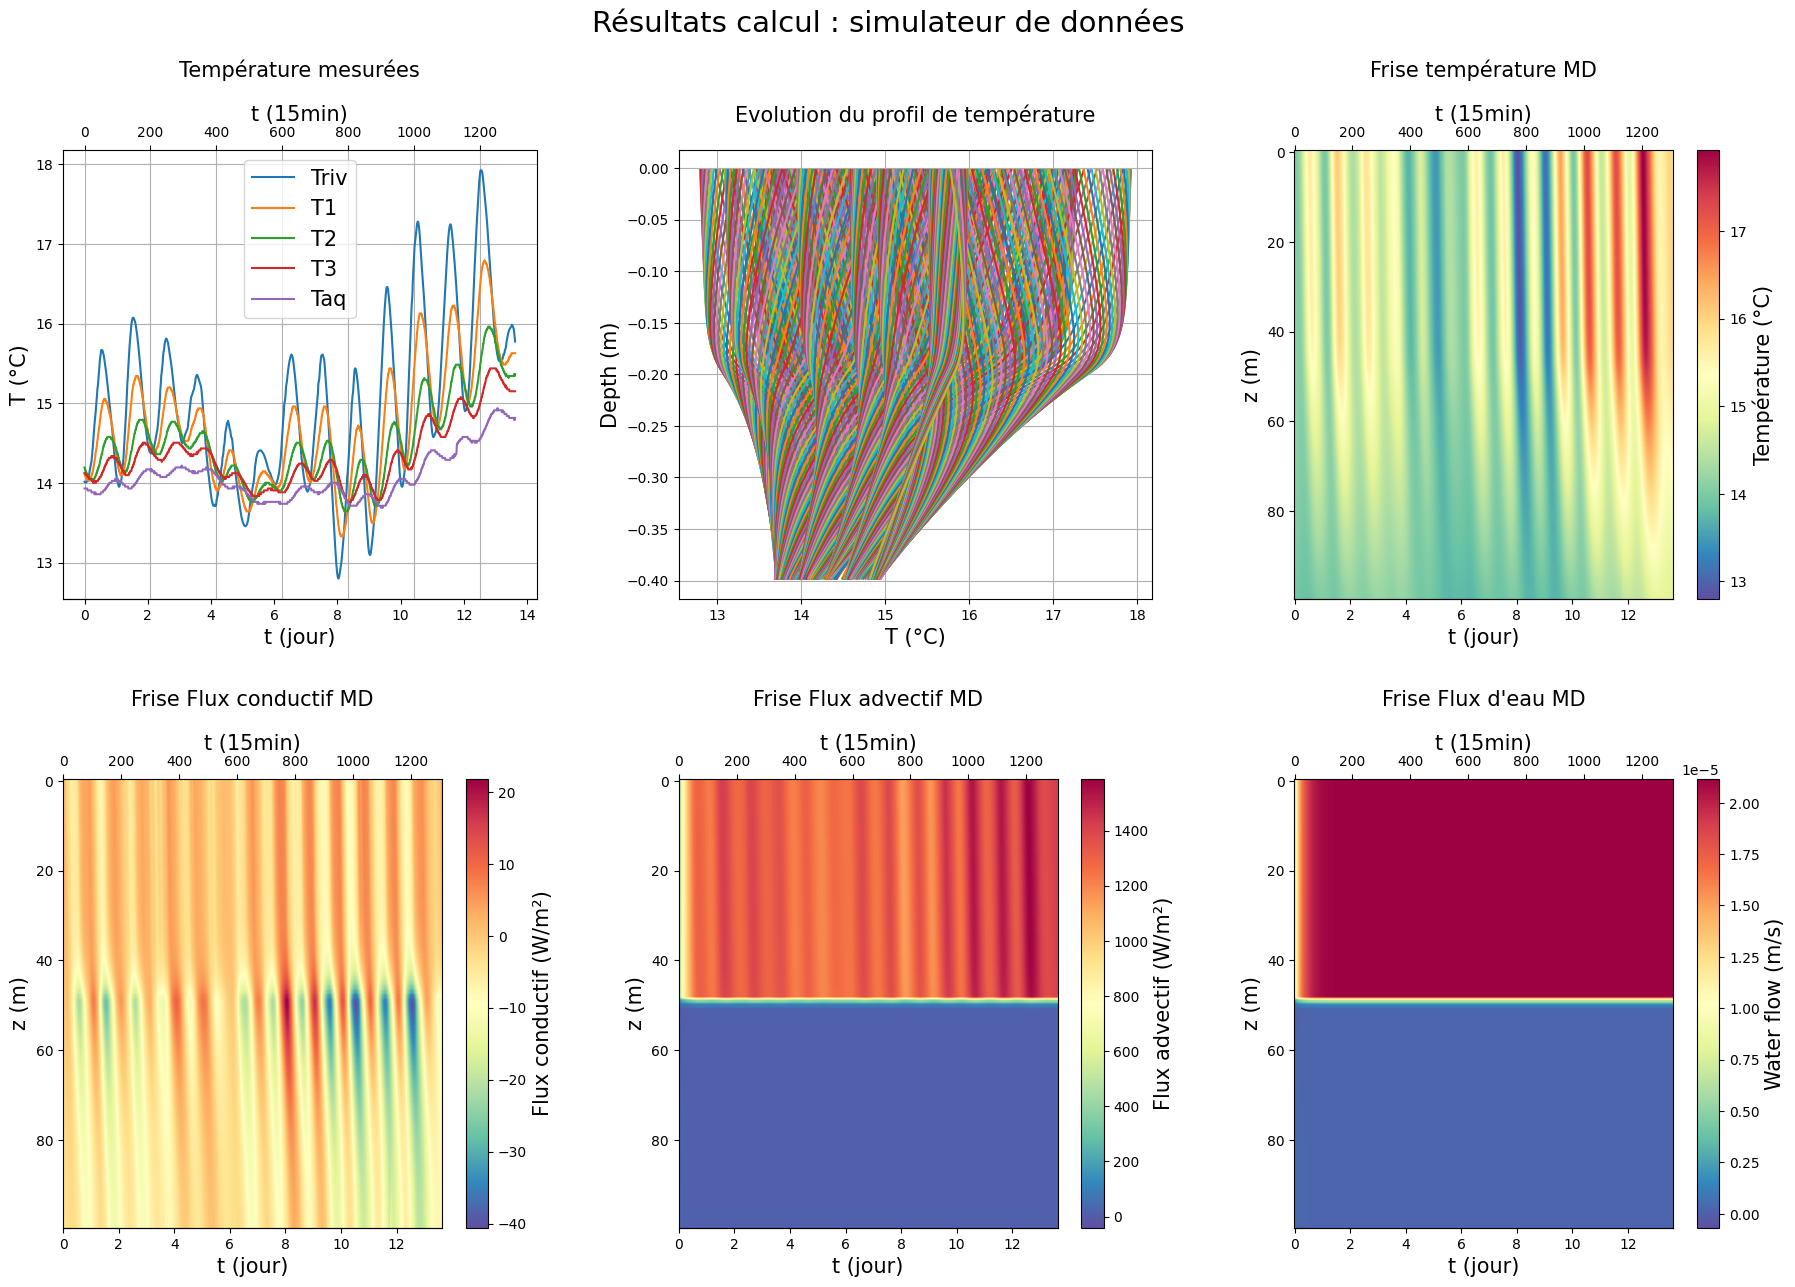

In [ ]:
col.plot_CALC_results(nt=len(col._times))

### zhan: cas charge hydraulique stratifié temporellement permanante

charge hydraulique sur chaque interface [0.85553173 0.84706112 0.        ]


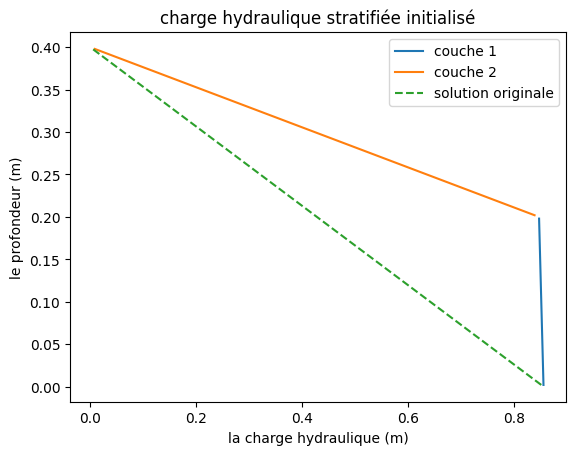

--- Compute Solve Transi ---
Couche 1 : ends at 0.2 m. Parametres(moinslog10K=5, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Couche 2 : ends at 0.4 m. Parametres(moinslog10K=7, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Hinter [0.85553173 0.84706112 0.        ]


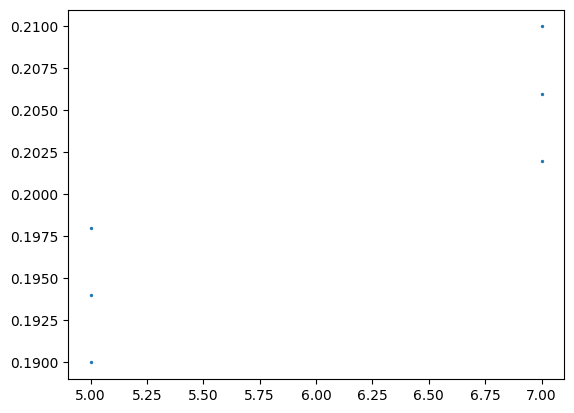

zhan moinslog10K_list [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.
 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.
 7. 7. 7. 7.]
length de chaque couche 
50
50
zhan 49
0.8471458218014972
0.8470611156899283
0.838590504533029


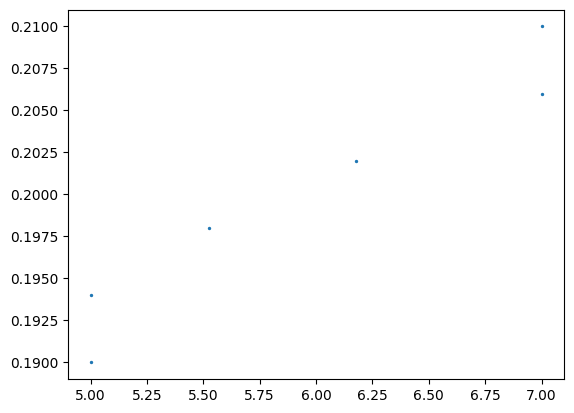

H_riv [0.85544702 0.85544702 0.85544702 ... 0.85544702 0.85544702 0.85544702]
H_aq [0.00847061 0.00847061 0.00847061 ... 0.00847061 0.00847061 0.00847061]
begin modification
K1, K2, dz 1e-05 1e-07 0.004
zhan test 0.8470611156899283
Done.


In [ ]:
col.compute_solve_transi(layers_list, nb_cells=100, verbose = True)

In [ ]:
print(col._H_res)

[[0.855447   0.854487   0.8541983  ... 0.8512125  0.85121256 0.8512125 ]
 [0.8552776  0.85267943 0.85162556 ... 0.8427434  0.8427437  0.8427434 ]
 [0.8551082  0.8508698  0.8490533  ... 0.8342745  0.83427453 0.8342745 ]
 ...
 [0.04235306 0.04950895 0.04877608 ... 0.02964479 0.02964479 0.0296448 ]
 [0.02541183 0.03479845 0.03172921 ... 0.02117512 0.02117512 0.02117513]
 [0.00847061 0.02078326 0.01399145 ... 0.01270545 0.01270545 0.01270545]]


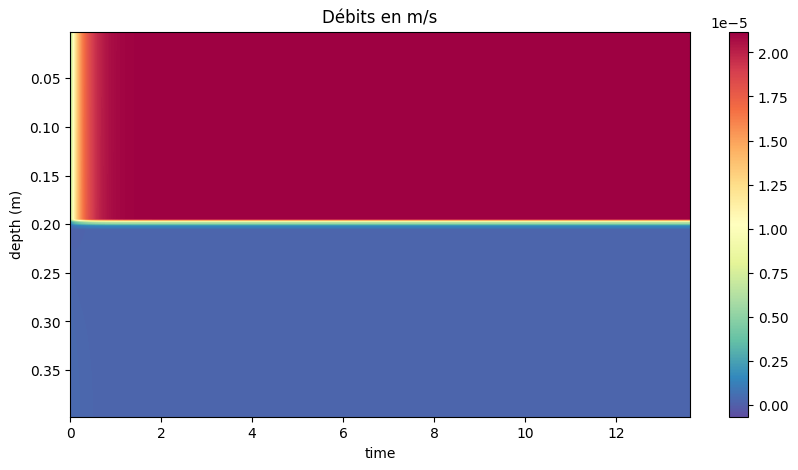

In [ ]:
flows = col.get_flows_solve()

fig, ax = plt.subplots(figsize=(10, 5), facecolor = 'w')

im = ax.imshow(
    flows,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = "Spectral_r"
)

ax.set_xlabel("time")
ax.set_ylabel("depth (m)")
ax.set_title("Débits en m/s")
plt.colorbar(im)
plt.show()

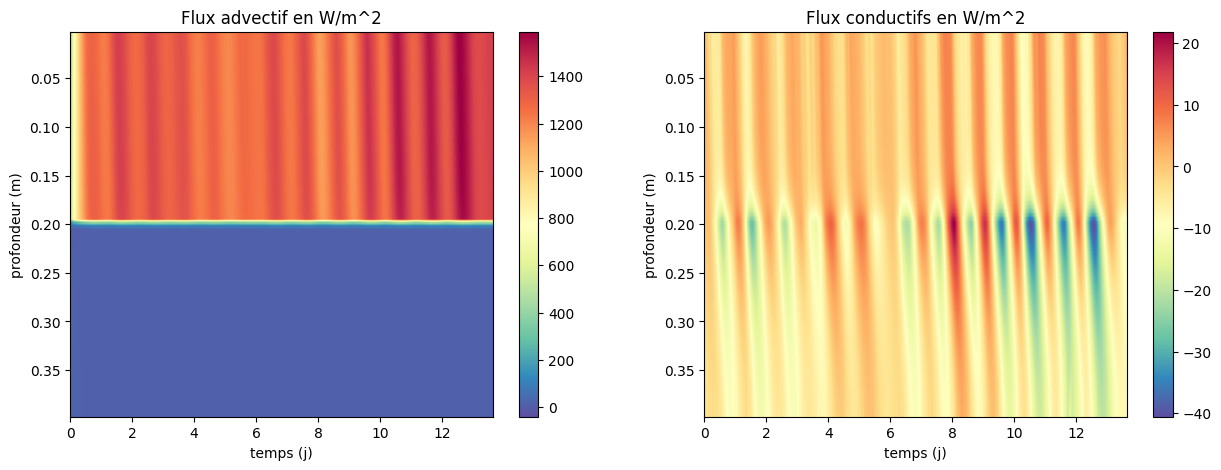

In [ ]:
flux_advectifs = col.get_advec_flows_solve()
flux_conductifs = col.get_conduc_flows_solve()

fig, axes = plt.subplots(1, 2, figsize=(15, 5), facecolor = 'w')

im0 = axes[0].imshow(
    flux_advectifs,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = 'Spectral_r'
)

axes[0].set_xlabel("temps (j)")
axes[0].set_ylabel("profondeur (m)")
axes[0].set_title("Flux advectif en W/m^2")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(
    flux_conductifs,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = 'Spectral_r'
)

axes[1].set_xlabel("temps (j)")
axes[1].set_ylabel("profondeur (m)")
axes[1].set_title("Flux conductifs en W/m^2")
plt.colorbar(im1, ax=axes[1])

plt.show()

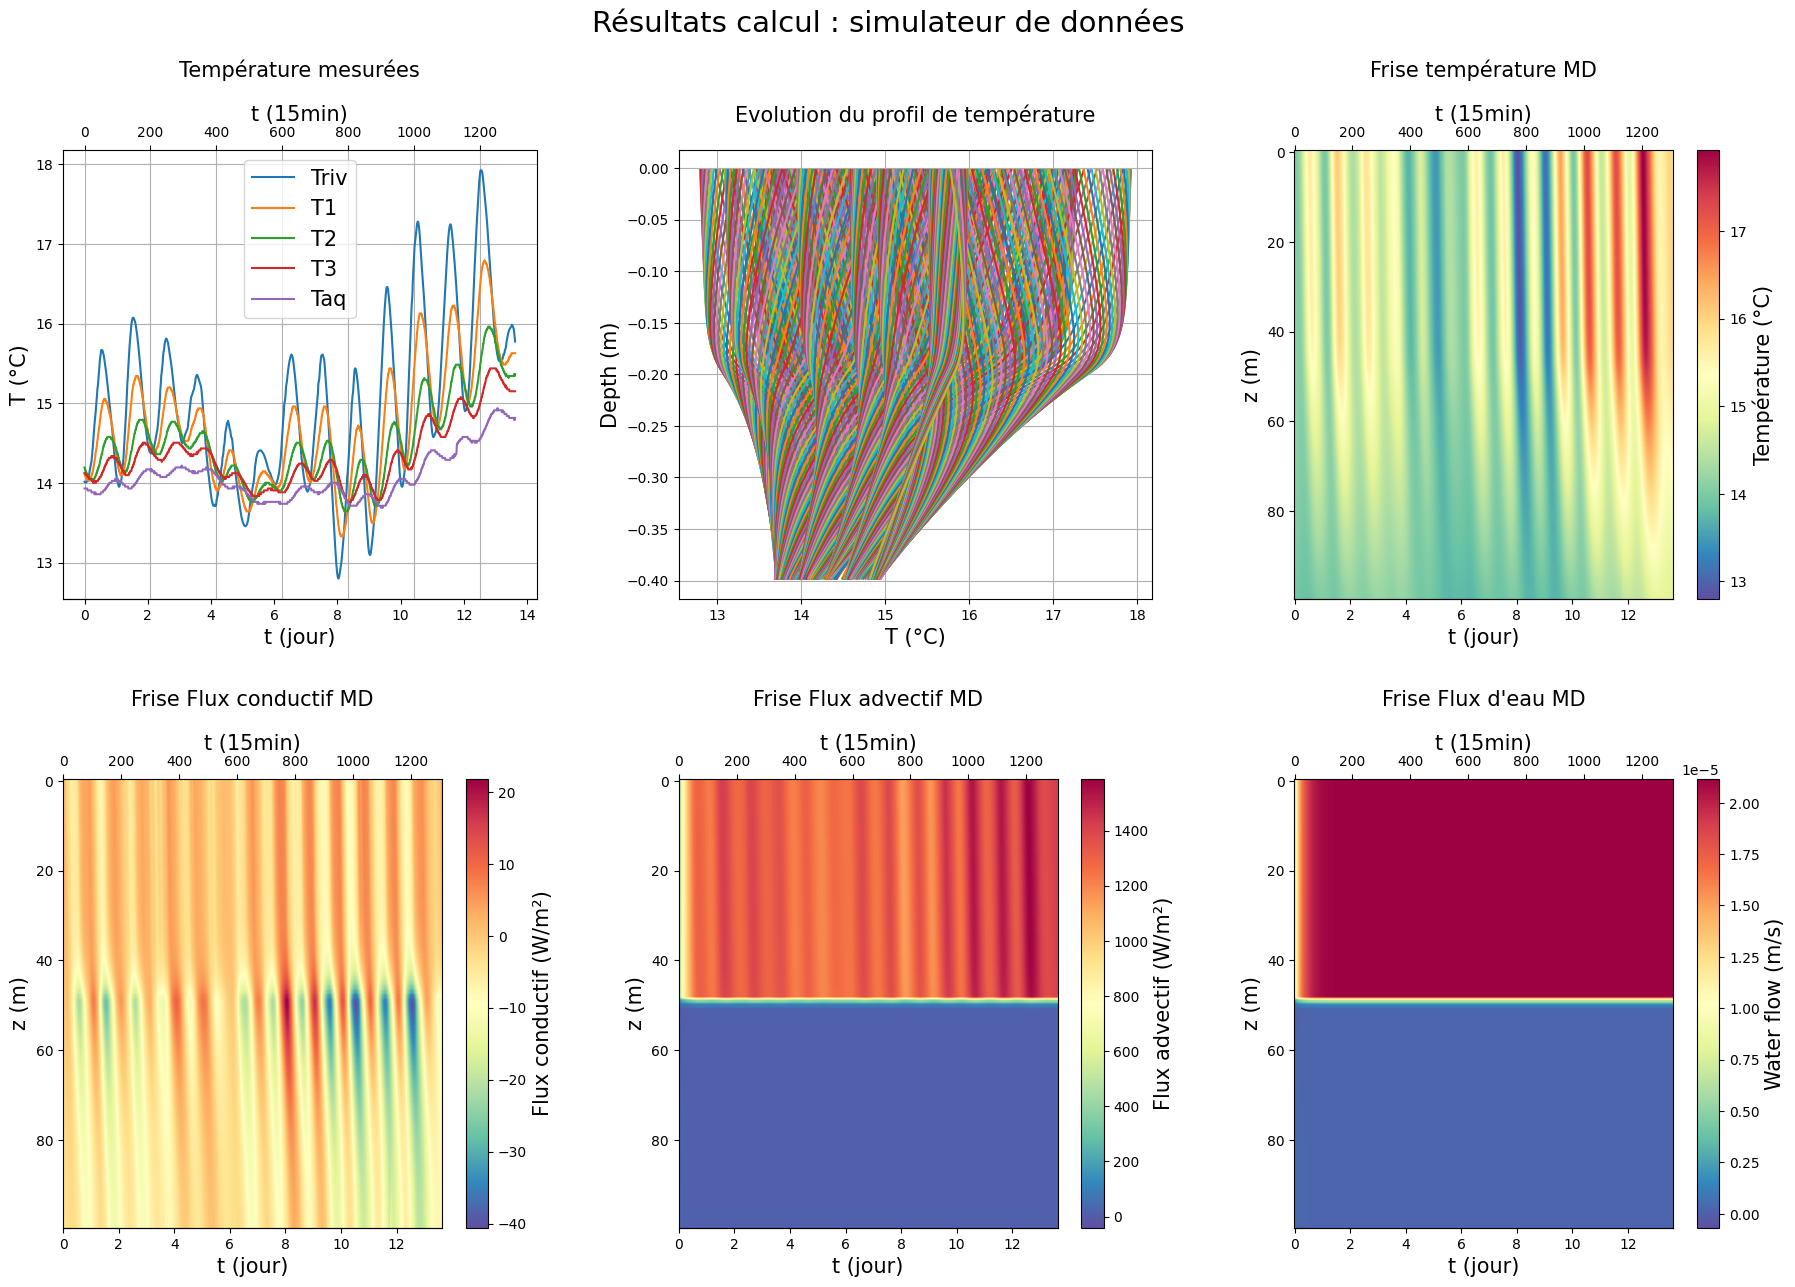

In [ ]:
col.plot_CALC_results(nt=len(col._times))